In [24]:
# ============================================================
# [Section 1] Installation & Imports
# Kaggle inclut déjà torch/torchvision, on vérifie et on importe.
# ============================================================

import os, glob, random, math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

print("Torch:", torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Torch: 2.8.0+cu126
Device: cuda


In [29]:
# ============================================================
# [Section 2] Reproductibilité (Seed)
# ============================================================

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)


In [3]:
# =========================
# 3) IMPORTS
# =========================
import os, glob, random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


In [30]:
# =========================
#  — Check dataset path (Kaggle Input)
# =========================
import os, glob

INPUT_DIR = "/kaggle/input"
print("Datasets in /kaggle/input:\n", os.listdir(INPUT_DIR))

# Afficher quelques fichiers pour repérer la structure
all_files = glob.glob(INPUT_DIR + "/**/*", recursive=True)
print("\nTotal files found:", len(all_files))
print("Sample paths:")
for p in all_files[:40]:
    print(p)


Datasets in /kaggle/input:
 ['datasets']

Total files found: 30649
Sample paths:
/kaggle/input/datasets
/kaggle/input/datasets/mstjebashazida
/kaggle/input/datasets/mstjebashazida/affectnet
/kaggle/input/datasets/mstjebashazida/affectnet/archive (3)
/kaggle/input/datasets/mstjebashazida/affectnet/archive (3)/Test
/kaggle/input/datasets/mstjebashazida/affectnet/archive (3)/Train
/kaggle/input/datasets/mstjebashazida/affectnet/archive (3)/labels.csv
/kaggle/input/datasets/mstjebashazida/affectnet/archive (3)/Test/surprise
/kaggle/input/datasets/mstjebashazida/affectnet/archive (3)/Test/fear
/kaggle/input/datasets/mstjebashazida/affectnet/archive (3)/Test/neutral
/kaggle/input/datasets/mstjebashazida/affectnet/archive (3)/Test/sad
/kaggle/input/datasets/mstjebashazida/affectnet/archive (3)/Test/disgust
/kaggle/input/datasets/mstjebashazida/affectnet/archive (3)/Test/Contempt
/kaggle/input/datasets/mstjebashazida/affectnet/archive (3)/Test/happy
/kaggle/input/datasets/mstjebashazida/affect

In [31]:
# ============================================================
# Dataset path (AffectNet Kaggle)
# ============================================================

from pathlib import Path
import os

DATA_ROOT = Path("/kaggle/input/datasets/mstjebashazida/affectnet/archive (3)")
TRAIN_DIR = DATA_ROOT / "Train"
TEST_DIR  = DATA_ROOT / "Test"

print("Train exists:", TRAIN_DIR.exists())
print("Test exists :", TEST_DIR.exists())

train_classes = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])
test_classes  = sorted([d.name for d in TEST_DIR.iterdir() if d.is_dir()])

print("Train classes:", train_classes)
print("Test classes :", test_classes)


Train exists: True
Test exists : True
Train classes: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Test classes : ['Anger', 'Contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [41]:
# ============================================================
# [Section A] Fixed class mapping (8 emotions) + normalize
# ============================================================

from pathlib import Path
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

DATA_ROOT = Path("/kaggle/input/datasets/mstjebashazida/affectnet/archive (3)")
TRAIN_DIR = DATA_ROOT / "Train"
TEST_DIR  = DATA_ROOT / "Test"

def normalize_name(name: str) -> str:
    return name.strip().lower()

# Mapping fixe -> IDs stables (important pour GitHub + rapport)
CLASSES = ["anger", "contempt", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
class_to_idx = {c:i for i,c in enumerate(CLASSES)}
idx_to_class = {i:c for c,i in class_to_idx.items()}

print("Fixed classes:", CLASSES)
print("class_to_idx:", class_to_idx)


Fixed classes: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class_to_idx: {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7}


In [42]:
# ============================================================
# [Section B] AffectNet folder Dataset with fixed label mapping
# ============================================================

class AffectNetFolderDataset(Dataset):
    """
    Dataset basé sur:
      root/Train/<emotion>/*.jpg
      root/Test/<emotion>/*.jpg
    Avec mapping fixe CLASSES pour stabilité.
    """
    def __init__(self, root_dir: Path, split="Train", transform=None):
        self.root = root_dir / split
        self.transform = transform
        self.samples = []

        for class_dir in self.root.iterdir():
            if not class_dir.is_dir():
                continue
            raw = class_dir.name
            lbl = normalize_name(raw)

            if lbl not in class_to_idx:
                continue  # sécurité

            paths = glob.glob(str(class_dir / "*.jpg")) + glob.glob(str(class_dir / "*.png"))
            for p in paths:
                self.samples.append((p, class_to_idx[lbl]))

        # pour info
        self.num_classes = len(CLASSES)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, y = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, y

print("Dataset class ready.")


Dataset class ready.


In [57]:
# ============================================================
# [Section C] Transforms + DataLoaders
# ============================================================

img_size = 128

train_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

train_ds = AffectNetFolderDataset(DATA_ROOT, split="Train", transform=train_tf)
test_ds  = AffectNetFolderDataset(DATA_ROOT, split="Test",  transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


print("Train size:", len(train_ds))
print("Test size :", len(test_ds))



Train size: 16108
Test size : 14518


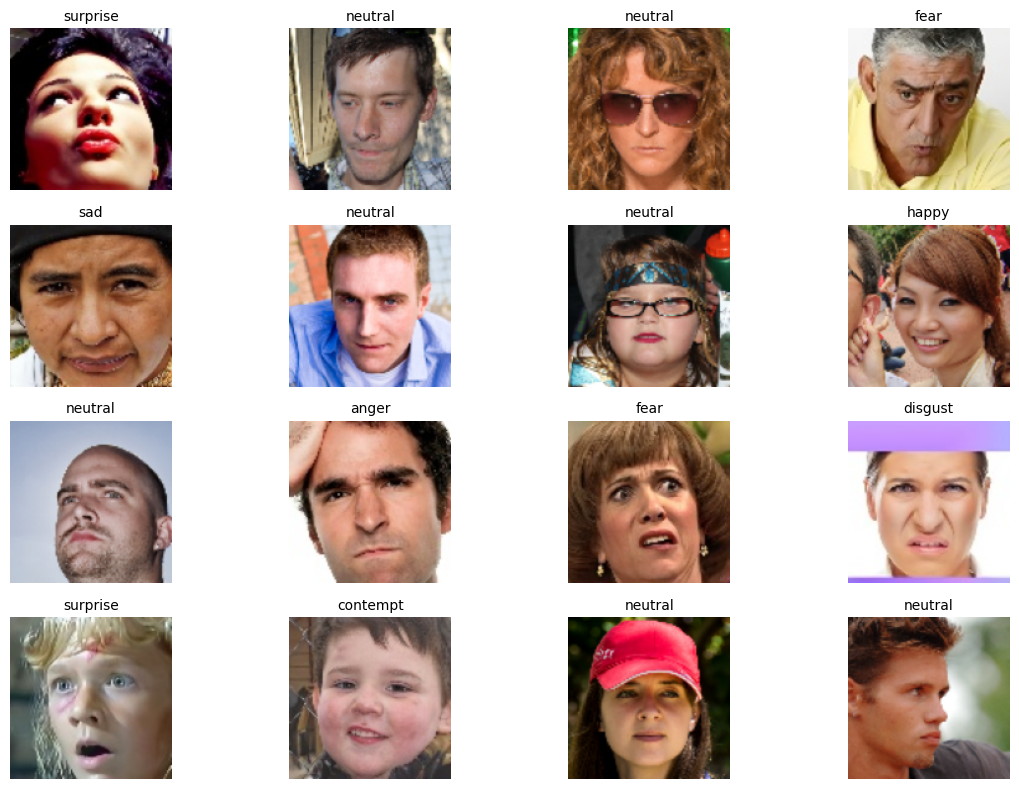

In [58]:
# ============================================================
# [Section D - Improved] Visualisation avec label sous chaque image
# ============================================================

import matplotlib.pyplot as plt

x, y = next(iter(train_loader))

num_images = 16  # combien d'images afficher
cols = 4
rows = num_images // cols

plt.figure(figsize=(12, 8))

for i in range(num_images):
    plt.subplot(rows, cols, i+1)
    img = x[i].permute(1,2,0).cpu().numpy()
    label_name = idx_to_class[int(y[i])]
    
    plt.imshow(img)
    plt.title(label_name, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [59]:
# ============================================================
# [Section E] Emotion classifier (ResNet18) + training loop
# ============================================================

import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import accuracy_score, f1_score

class EmotionClassifier(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
    def forward(self, x):
        return self.backbone(x)

clf = EmotionClassifier(num_classes=len(CLASSES)).to(device)

def eval_classifier(model, loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(1)
            ys.extend(y.cpu().numpy().tolist())
            ps.extend(pred.cpu().numpy().tolist())
    acc = accuracy_score(ys, ps)
    f1  = f1_score(ys, ps, average="macro")
    return acc, f1

optimizer = torch.optim.AdamW(clf.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

epochs = 3
for ep in range(1, epochs+1):
    clf.train()
    total_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = clf(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)

    train_loss = total_loss / len(train_loader.dataset)
    acc, f1 = eval_classifier(clf, test_loader)
    print(f"Epoch {ep}/{epochs} | train_loss={train_loss:.4f} | test_acc={acc:.4f} | test_f1={f1:.4f}")


Epoch 1/3 | train_loss=1.1551 | test_acc=0.6165 | test_f1=0.5650
Epoch 2/3 | train_loss=0.7894 | test_acc=0.6474 | test_f1=0.6064
Epoch 3/3 | train_loss=0.6204 | test_acc=0.6588 | test_f1=0.6140


Définir le modèle CVAE conditionnel

Définir la loss (Reconstruction + KL)

Entraîner

Générer par émotion

Sauvegarder images + modèle

In [60]:
# ============================================================
# [Section F2] CVAE for 128x128 (sharper than 64x64)
# ============================================================

import torch.nn as nn
import torch.nn.functional as F

latent_dim = 256
num_classes = len(CLASSES)

def one_hot(labels, num_classes):
    return F.one_hot(labels, num_classes=num_classes).float()

class CVAE128(nn.Module):
    def __init__(self, num_classes=8, latent_dim=256):
        super().__init__()
        self.num_classes = num_classes
        self.latent_dim = latent_dim

        # Encoder: 128 -> 64 -> 32 -> 16 -> 8
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),    # 64
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),   # 32
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),  # 16
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU()  # 8
        )

        self.enc_out_dim = 256 * 8 * 8

        self.fc_mu = nn.Linear(self.enc_out_dim + num_classes, latent_dim)
        self.fc_logvar = nn.Linear(self.enc_out_dim + num_classes, latent_dim)

        self.fc_decode = nn.Linear(latent_dim + num_classes, self.enc_out_dim)

        # Decoder: 8 -> 16 -> 32 -> 64 -> 128
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(), # 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),  # 32
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),   # 64
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()  # 128
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        b = x.size(0)
        h = self.encoder(x).view(b, -1)

        y_oh = one_hot(y, self.num_classes).to(x.device)
        hy = torch.cat([h, y_oh], dim=1)

        mu = self.fc_mu(hy)
        logvar = self.fc_logvar(hy)
        z = self.reparameterize(mu, logvar)

        zy = torch.cat([z, y_oh], dim=1)
        hd = self.fc_decode(zy).view(b, 256, 8, 8)

        x_recon = self.decoder(hd)
        return x_recon, mu, logvar


In [61]:
# ============================================================
# [Section G] CVAE Loss Function
# Loss = Reconstruction (MSE) + Beta * KL Divergence
# ============================================================

beta = 0.5  # hyperparameter

def cvae_loss(x_recon, x, mu, logvar):
    
    # Reconstruction Loss
    recon_loss = F.mse_loss(x_recon, x, reduction="mean")
    
    # KL Divergence
    kl_loss = -0.5 * torch.mean(
        1 + logvar - mu.pow(2) - logvar.exp()
    )
    
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss, recon_loss.detach(), kl_loss.detach()


In [53]:
# ============================================================
# [Section H - Improved] CVAE Training with KL warm-up
# ============================================================

optimizer_cvae = torch.optim.Adam(cvae.parameters(), lr=2e-4)

epochs_cvae = 10
beta_max = 0.5

for epoch in range(1, epochs_cvae + 1):
    cvae.train()
    
    # KL warm-up: beta augmente progressivement
    beta = beta_max * (epoch / epochs_cvae)
    
    total_loss = total_rec = total_kl = 0.0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        optimizer_cvae.zero_grad()
        x_recon, mu, logvar = cvae(x, y)
        
        recon_loss = F.mse_loss(x_recon, x, reduction="mean")
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        
        loss = recon_loss + beta * kl_loss
        loss.backward()
        optimizer_cvae.step()
        
        total_loss += loss.item() * x.size(0)
        total_rec  += recon_loss.item() * x.size(0)
        total_kl   += kl_loss.item() * x.size(0)
    
    n = len(train_loader.dataset)
    print(f"Epoch {epoch}/{epochs_cvae} | beta={beta:.3f} | "
          f"Loss={total_loss/n:.4f} | Recon={total_rec/n:.4f} | KL={total_kl/n:.4f}")


Epoch 1/10 | beta=0.050 | Loss=0.0401 | Recon=0.0354 | KL=0.0952
Epoch 2/10 | beta=0.100 | Loss=0.0415 | Recon=0.0343 | KL=0.0728
Epoch 3/10 | beta=0.150 | Loss=0.0432 | Recon=0.0350 | KL=0.0545
Epoch 4/10 | beta=0.200 | Loss=0.0450 | Recon=0.0362 | KL=0.0438
Epoch 5/10 | beta=0.250 | Loss=0.0460 | Recon=0.0369 | KL=0.0363
Epoch 6/10 | beta=0.300 | Loss=0.0470 | Recon=0.0377 | KL=0.0310
Epoch 7/10 | beta=0.350 | Loss=0.0482 | Recon=0.0387 | KL=0.0271
Epoch 8/10 | beta=0.400 | Loss=0.0493 | Recon=0.0397 | KL=0.0241
Epoch 9/10 | beta=0.450 | Loss=0.0503 | Recon=0.0406 | KL=0.0215
Epoch 10/10 | beta=0.500 | Loss=0.0512 | Recon=0.0415 | KL=0.0194


In [62]:
# ============================================================
# [Section H - 128x128] CVAE Training with KL warm-up
# ============================================================


latent_dim = 256
num_classes = len(CLASSES)

cvae = CVAE128(num_classes=num_classes, latent_dim=latent_dim).to(device)
optimizer_cvae = torch.optim.Adam(cvae.parameters(), lr=2e-4)

epochs_cvae = 10
beta_max = 0.2

for epoch in range(1, epochs_cvae + 1):
    cvae.train()
    beta = beta_max * (epoch / epochs_cvae)

    total_loss = 0.0
    total_rec  = 0.0
    total_kl   = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer_cvae.zero_grad()
        x_recon, mu, logvar = cvae(x, y)

        recon_loss = F.mse_loss(x_recon, x, reduction="mean")
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        loss = recon_loss + beta * kl_loss
        loss.backward()
        optimizer_cvae.step()

        total_loss += loss.item() * x.size(0)
        total_rec  += recon_loss.item() * x.size(0)
        total_kl   += kl_loss.item() * x.size(0)

    n = len(train_loader.dataset)
    print(f"Epoch {epoch}/{epochs_cvae} | beta={beta:.3f} | "
          f"Loss={total_loss/n:.4f} | Recon={total_rec/n:.4f} | KL={total_kl/n:.4f}")


Epoch 1/10 | beta=0.020 | Loss=0.0490 | Recon=0.0463 | KL=0.1325
Epoch 2/10 | beta=0.040 | Loss=0.0334 | Recon=0.0274 | KL=0.1505
Epoch 3/10 | beta=0.060 | Loss=0.0322 | Recon=0.0253 | KL=0.1152
Epoch 4/10 | beta=0.080 | Loss=0.0322 | Recon=0.0248 | KL=0.0926
Epoch 5/10 | beta=0.100 | Loss=0.0329 | Recon=0.0250 | KL=0.0791
Epoch 6/10 | beta=0.120 | Loss=0.0338 | Recon=0.0255 | KL=0.0693
Epoch 7/10 | beta=0.140 | Loss=0.0347 | Recon=0.0261 | KL=0.0618
Epoch 8/10 | beta=0.160 | Loss=0.0356 | Recon=0.0267 | KL=0.0558
Epoch 9/10 | beta=0.180 | Loss=0.0365 | Recon=0.0273 | KL=0.0510
Epoch 10/10 | beta=0.200 | Loss=0.0374 | Recon=0.0280 | KL=0.0470


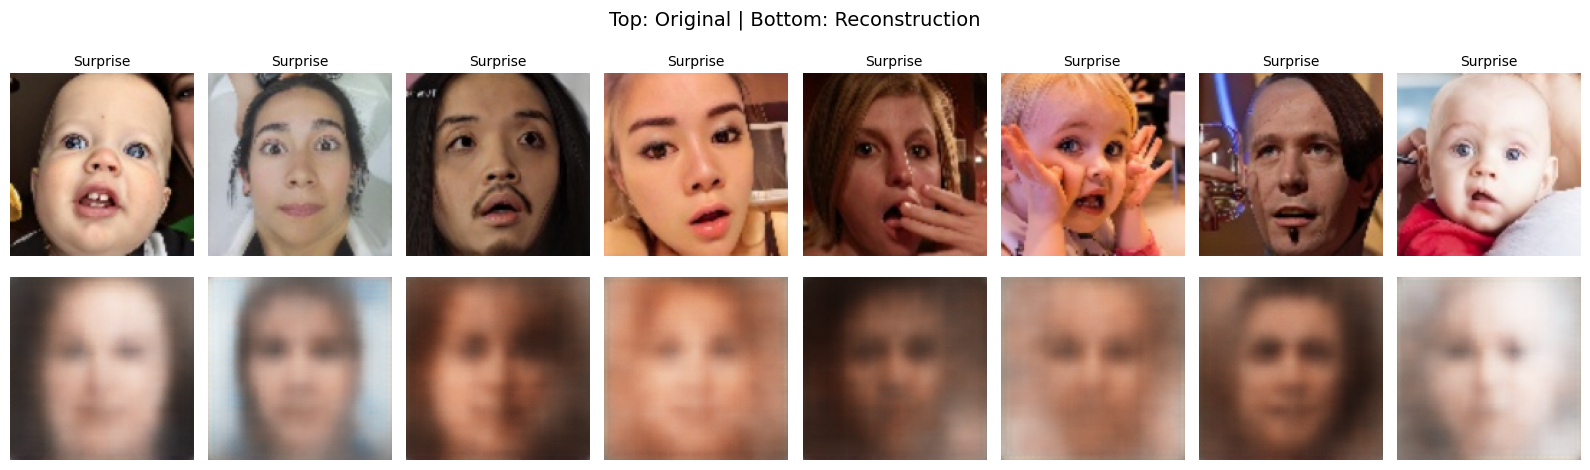

In [63]:
# ============================================================
# [Section I - 128x128] Reconstruction Visualization (with labels)
# ============================================================

import matplotlib.pyplot as plt

cvae.eval()
x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)

with torch.no_grad():
    x_recon, _, _ = cvae(x, y)

n_show = 8  # nombre d'images à afficher
plt.figure(figsize=(16, 5))

for i in range(n_show):
    # -------- Original (top row)
    plt.subplot(2, n_show, i+1)
    img = x[i].detach().cpu().permute(1,2,0).numpy()
    plt.imshow(img)
    plt.axis("off")
    plt.title(idx_to_class[int(y[i])].capitalize(), fontsize=10)

    # -------- Reconstruction (bottom row)
    plt.subplot(2, n_show, n_show + i + 1)
    rec = x_recon[i].detach().cpu().permute(1,2,0).numpy()
    plt.imshow(rec)
    plt.axis("off")

plt.suptitle("Top: Original | Bottom: Reconstruction", fontsize=14)
plt.tight_layout()
plt.show()


In [55]:
# ============================================================
# [Section H - Improved v2] CVAE Training with KL warm-up
# Modifications:
# - Beta réduit (0.2 au lieu de 0.5)
# - Reconstruction loss = BCE au lieu de MSE
# ============================================================

optimizer_cvae = torch.optim.Adam(cvae.parameters(), lr=2e-4)

epochs_cvae = 10
beta_max = 0.2   # 

for epoch in range(1, epochs_cvae + 1):
    cvae.train()
    
    # KL warm-up progressif
    beta = beta_max * (epoch / epochs_cvae)
    
    total_loss = 0.0
    total_rec  = 0.0
    total_kl   = 0.0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        optimizer_cvae.zero_grad()
        
        x_recon, mu, logvar = cvae(x, y)
        
        #  Reconstruction BCE (meilleure netteté que MSE)
        recon_loss = F.binary_cross_entropy(x_recon, x, reduction="mean")
        
        # KL divergence
        kl_loss = -0.5 * torch.mean(
            1 + logvar - mu.pow(2) - logvar.exp()
        )
        
        loss = recon_loss + beta * kl_loss
        
        loss.backward()
        optimizer_cvae.step()
        
        total_loss += loss.item() * x.size(0)
        total_rec  += recon_loss.item() * x.size(0)
        total_kl   += kl_loss.item() * x.size(0)
    
    n = len(train_loader.dataset)
    
    print(f"Epoch {epoch}/{epochs_cvae} | "
          f"beta={beta:.3f} | "
          f"Loss={total_loss/n:.4f} | "
          f"Recon={total_rec/n:.4f} | "
          f"KL={total_kl/n:.4f}")


Epoch 1/10 | beta=0.020 | Loss=0.5894 | Recon=0.5856 | KL=0.1916
Epoch 2/10 | beta=0.040 | Loss=0.5834 | Recon=0.5748 | KL=0.2151
Epoch 3/10 | beta=0.060 | Loss=0.5844 | Recon=0.5728 | KL=0.1931
Epoch 4/10 | beta=0.080 | Loss=0.5863 | Recon=0.5728 | KL=0.1693
Epoch 5/10 | beta=0.100 | Loss=0.5883 | Recon=0.5731 | KL=0.1514
Epoch 6/10 | beta=0.120 | Loss=0.5901 | Recon=0.5737 | KL=0.1373
Epoch 7/10 | beta=0.140 | Loss=0.5922 | Recon=0.5745 | KL=0.1260
Epoch 8/10 | beta=0.160 | Loss=0.5943 | Recon=0.5756 | KL=0.1165
Epoch 9/10 | beta=0.180 | Loss=0.5963 | Recon=0.5768 | KL=0.1082
Epoch 10/10 | beta=0.200 | Loss=0.5981 | Recon=0.5778 | KL=0.1015


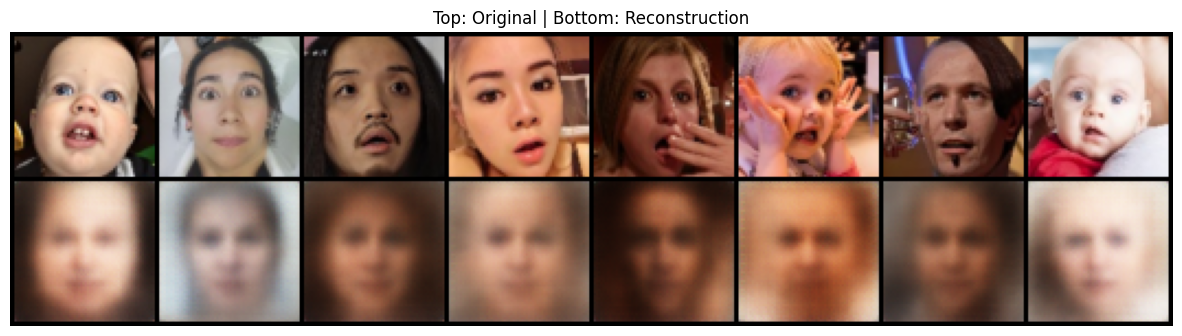

In [56]:
# ============================================================
# [Section I] Reconstruction Visualization
# ============================================================

cvae.eval()
x, y = next(iter(test_loader))
x = x.to(device)
y = y.to(device)

with torch.no_grad():
    x_recon, _, _ = cvae(x, y)

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

n_show = 8

comparison = torch.cat([x[:n_show], x_recon[:n_show]])
grid = make_grid(comparison.cpu(), nrow=n_show)

plt.figure(figsize=(15,4))
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.title("Top: Original | Bottom: Reconstruction")
plt.show()


In [64]:
# ============================================================
# [Section L] Perceptual Loss (VGG16 features)
# Objectif: comparer x et x_recon dans l'espace des features (pas pixel)
# ============================================================

import torchvision.models as models
import torch.nn as nn
import torch

# VGG16 pre-trained
vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features.to(device).eval()

# On gèle VGG (pas d'apprentissage)
for p in vgg.parameters():
    p.requires_grad = False

# On prend un "slice" des premières couches (features bas niveau)
#  16 ou 23 ++++"haut niveau"
VGG_SLICE_END = 16
vgg_slice = nn.Sequential(*list(vgg.children())[:VGG_SLICE_END]).to(device).eval()

# Normalisation ImageNet pour VGG (important)
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)

def vgg_preprocess(x):
    # x est dans [0,1] -> normaliser ImageNet
    return (x - IMAGENET_MEAN) / IMAGENET_STD

print("VGG perceptual slice ready.")


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 213MB/s] 


VGG perceptual slice ready.


In [65]:
# ============================================================
# [Section M] CVAE loss with Perceptual term
# Loss = MSE + lambda_perc * Perceptual + beta * KL
# ============================================================

import torch.nn.functional as F

lambda_perc = 0.2  # poids perceptuel (0.1 à 0.5 )

def cvae_loss_perceptual(x_recon, x, mu, logvar, beta):
    # Pixel loss
    recon_loss = F.mse_loss(x_recon, x, reduction="mean")

    # Perceptual loss (VGG feature space)
    fx = vgg_slice(vgg_preprocess(x))
    fr = vgg_slice(vgg_preprocess(x_recon))
    perc_loss = F.mse_loss(fr, fx, reduction="mean")

    # KL divergence
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    total = recon_loss + lambda_perc * perc_loss + beta * kl_loss
    return total, recon_loss.detach(), perc_loss.detach(), kl_loss.detach()


In [66]:
# ============================================================
# [Section N] Fine-tune CVAE with Perceptual Loss (sharper)
# ============================================================

optimizer_cvae = torch.optim.Adam(cvae.parameters(), lr=1e-4)

epochs_ft = 5
beta_max = 0.2

for epoch in range(1, epochs_ft + 1):
    cvae.train()
    beta = beta_max * (epoch / epochs_ft)

    total = rec_t = perc_t = kl_t = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer_cvae.zero_grad()

        x_recon, mu, logvar = cvae(x, y)
        loss, rec, perc, kl = cvae_loss_perceptual(x_recon, x, mu, logvar, beta)

        loss.backward()
        optimizer_cvae.step()

        total += loss.item() * x.size(0)
        rec_t += rec.item() * x.size(0)
        perc_t += perc.item() * x.size(0)
        kl_t  += kl.item() * x.size(0)

    n = len(train_loader.dataset)
    print(f"FT Epoch {epoch}/{epochs_ft} | beta={beta:.3f} | "
          f"Loss={total/n:.4f} | Recon={rec_t/n:.4f} | Perc={perc_t/n:.4f} | KL={kl_t/n:.4f}")


FT Epoch 1/5 | beta=0.040 | Loss=2.8930 | Recon=0.0360 | Perc=14.1673 | KL=0.5882
FT Epoch 2/5 | beta=0.080 | Loss=2.7538 | Recon=0.0355 | Perc=13.3901 | KL=0.5030
FT Epoch 3/5 | beta=0.120 | Loss=2.7006 | Recon=0.0340 | Perc=13.0524 | KL=0.4683
FT Epoch 4/5 | beta=0.160 | Loss=2.6719 | Recon=0.0330 | Perc=12.8416 | KL=0.4410
FT Epoch 5/5 | beta=0.200 | Loss=2.6556 | Recon=0.0323 | Perc=12.7001 | KL=0.4160


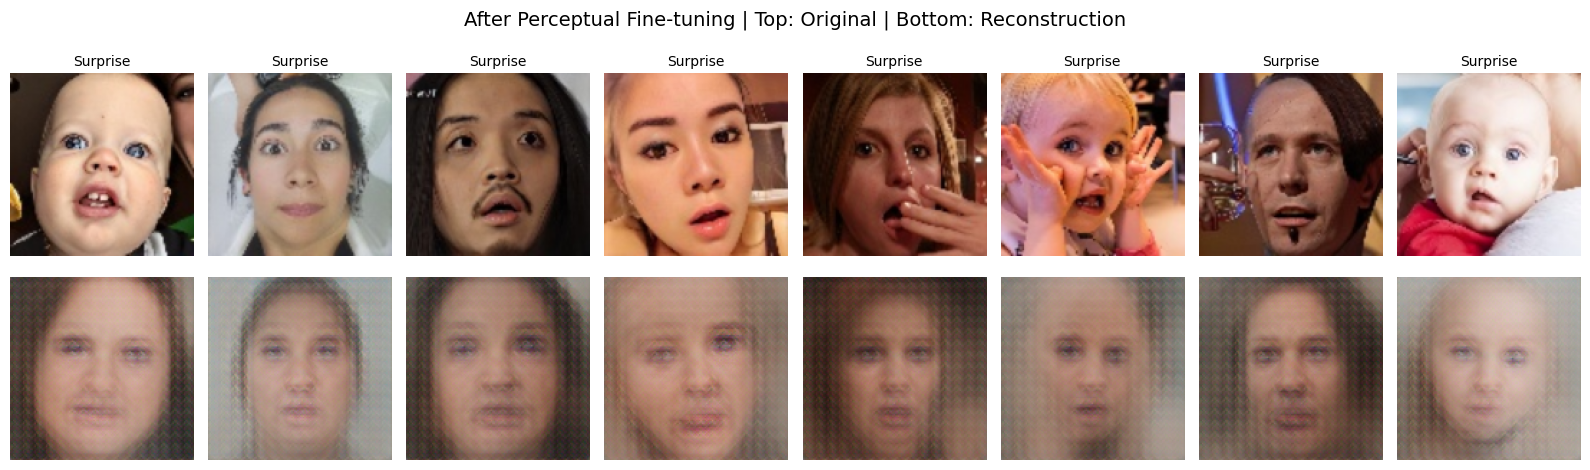

In [67]:
# ============================================================
# [Section O] Reconstruction after Perceptual Fine-tuning
# ============================================================

import matplotlib.pyplot as plt

cvae.eval()
x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)

with torch.no_grad():
    x_recon, _, _ = cvae(x, y)

n_show = 8
plt.figure(figsize=(16, 5))

for i in range(n_show):
    # Original
    plt.subplot(2, n_show, i+1)
    plt.imshow(x[i].cpu().permute(1,2,0))
    plt.axis("off")
    plt.title(idx_to_class[int(y[i])].capitalize(), fontsize=10)

    # Recon
    plt.subplot(2, n_show, n_show+i+1)
    plt.imshow(x_recon[i].cpu().permute(1,2,0))
    plt.axis("off")

plt.suptitle("After Perceptual Fine-tuning | Top: Original | Bottom: Reconstruction", fontsize=14)
plt.tight_layout()
plt.show()


In [70]:
# ============================================================
# [Section M] CVAE loss with Perceptual term
# Loss = MSE + lambda_perc * Perceptual + beta * KL
# ============================================================

import torch.nn.functional as F

lambda_perc = 0.05  # poids perceptuel (0.1 à 0.5 )

def cvae_loss_perceptual(x_recon, x, mu, logvar, beta):
    # Pixel loss
    recon_loss = F.mse_loss(x_recon, x, reduction="mean")

    # Perceptual loss (VGG feature space)
    fx = vgg_slice(vgg_preprocess(x))
    fr = vgg_slice(vgg_preprocess(x_recon))
    perc_loss = F.mse_loss(fr, fx, reduction="mean")

    # KL divergence
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    total = recon_loss + lambda_perc * perc_loss + beta * kl_loss
    return total, recon_loss.detach(), perc_loss.detach(), kl_loss.detach()


In [71]:
# ============================================================
# [Section N] Fine-tune CVAE with Perceptual Loss (sharper)
# ============================================================

optimizer_cvae = torch.optim.Adam(cvae.parameters(), lr=1e-4)

epochs_ft = 3
beta_max = 0.2

for epoch in range(1, epochs_ft + 1):
    cvae.train()
    beta = beta_max * (epoch / epochs_ft)

    total = rec_t = perc_t = kl_t = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer_cvae.zero_grad()

        x_recon, mu, logvar = cvae(x, y)
        loss, rec, perc, kl = cvae_loss_perceptual(x_recon, x, mu, logvar, beta)

        loss.backward()
        optimizer_cvae.step()

        total += loss.item() * x.size(0)
        rec_t += rec.item() * x.size(0)
        perc_t += perc.item() * x.size(0)
        kl_t  += kl.item() * x.size(0)

    n = len(train_loader.dataset)
    print(f"FT Epoch {epoch}/{epochs_ft} | beta={beta:.3f} | "
          f"Loss={total/n:.4f} | Recon={rec_t/n:.4f} | Perc={perc_t/n:.4f} | KL={kl_t/n:.4f}")


FT Epoch 1/3 | beta=0.067 | Loss=0.6849 | Recon=0.0249 | Perc=12.6691 | KL=0.3984
FT Epoch 2/3 | beta=0.133 | Loss=0.7002 | Recon=0.0252 | Perc=12.8087 | KL=0.2598
FT Epoch 3/3 | beta=0.200 | Loss=0.7107 | Recon=0.0264 | Perc=12.9298 | KL=0.1892


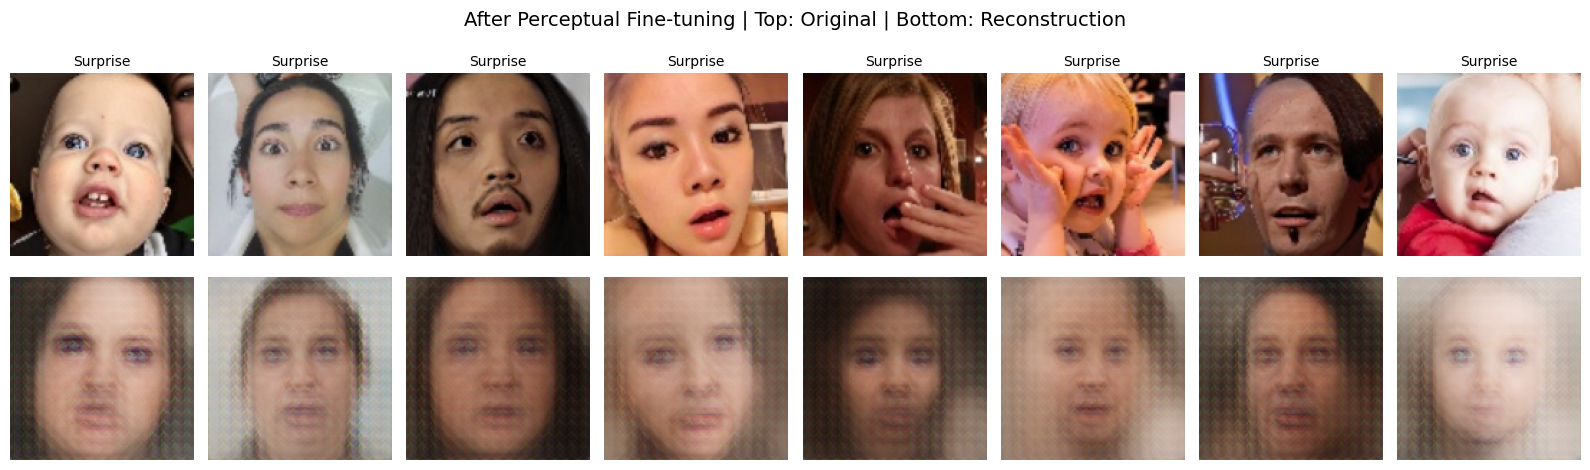

In [72]:
# ============================================================
# [Section O] Reconstruction after Perceptual Fine-tuning
# ============================================================

import matplotlib.pyplot as plt

cvae.eval()
x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)

with torch.no_grad():
    x_recon, _, _ = cvae(x, y)

n_show = 8
plt.figure(figsize=(16, 5))

for i in range(n_show):
    # Original
    plt.subplot(2, n_show, i+1)
    plt.imshow(x[i].cpu().permute(1,2,0))
    plt.axis("off")
    plt.title(idx_to_class[int(y[i])].capitalize(), fontsize=10)

    # Recon
    plt.subplot(2, n_show, n_show+i+1)
    plt.imshow(x_recon[i].cpu().permute(1,2,0))
    plt.axis("off")

plt.suptitle("After Perceptual Fine-tuning | Top: Original | Bottom: Reconstruction", fontsize=14)
plt.tight_layout()
plt.show()


In [81]:
# ============================================================
# [Section P] Load/Check classifier (ResNet18)
# ============================================================

import torch
import torch.nn as nn
import torchvision.models as models

class EmotionClassifier(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.backbone = models.resnet18(weights=None)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
    def forward(self, x):
        return self.backbone(x)

# Si clf existe déjà, garde-le
try:
    clf
    print("clf already in memory ✅")
except NameError:
    clf = EmotionClassifier(num_classes=len(CLASSES)).to(device)
    ckpt_path = "outputs/checkpoints/emotion_classifier_resnet18.pt"
    clf.load_state_dict(torch.load(ckpt_path, map_location=device))
    print("Loaded clf from:", ckpt_path)

clf.eval()


clf already in memory ✅


EmotionClassifier(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [82]:
# ============================================================
# [Section Q] Emotion control evaluation using the classifier
# ============================================================

import numpy as np
import torch.nn.functional as F

@torch.no_grad()
def generate_batch_for_emotion(model, emotion_id, n=64, latent_dim=256):
    model.eval()
    z = torch.randn(n, latent_dim).to(device)
    y = torch.full((n,), emotion_id, dtype=torch.long).to(device)
    y_oh = one_hot(y, len(CLASSES)).to(device)

    # Decoder path (compatible CVAE128: enc_out_dim = 256*8*8)
    zy = torch.cat([z, y_oh], dim=1)
    h = model.fc_decode(zy).view(n, 256, 8, 8)
    xgen = model.decoder(h)   # [0,1]
    return xgen

@torch.no_grad()
def emotion_control_report(cvae_model, clf_model, per_class=200, batch=64, latent_dim=256):
    clf_model.eval()
    results = {}

    for emo_id, emo_name in enumerate(CLASSES):
        correct = 0
        total = 0

        remaining = per_class
        while remaining > 0:
            n = min(batch, remaining)
            xgen = generate_batch_for_emotion(cvae_model, emo_id, n=n, latent_dim=latent_dim)

            logits = clf_model(xgen)
            pred = logits.argmax(1)

            correct += (pred == emo_id).sum().item()
            total += n
            remaining -= n

        results[emo_name] = correct / total

    overall = float(np.mean(list(results.values())))
    return results, overall

results, overall = emotion_control_report(cvae, clf, per_class=200, batch=64, latent_dim=latent_dim)

print("=== Emotion Control Accuracy (Generated -> Classifier) ===")
for k, v in results.items():
    print(f"{k:10s}: {v*100:5.1f}%")
print(f"\nMacro-average: {overall*100:.1f}%")


=== Emotion Control Accuracy (Generated -> Classifier) ===
anger     :   0.0%
contempt  :   2.0%
disgust   :   0.0%
fear      :   1.0%
happy     :  37.0%
neutral   :  95.0%
sad       :  77.5%
surprise  :  10.5%

Macro-average: 27.9%


In [84]:
# ============================================================
# [Section R] Results table 
# ============================================================

import pandas as pd

df = pd.DataFrame({"emotion": list(results.keys()),
                   "control_acc": [results[e] for e in results.keys()]})
df = df.sort_values("control_acc", ascending=False)
df


emotion  control_acc
5   neutral        0.950
6       sad        0.775
4     happy        0.370
7  surprise        0.105
1  contempt        0.020
3      fear        0.010
2   disgust        0.000
0     anger        0.000

In [83]:
# ============================================================
# [Section S] Install StyleGAN2-ADA (PyTorch)
# ============================================================

!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
%cd stylegan2-ada-pytorch
!pip -q install ninja


fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.
/kaggle/working/stylegan2-ada-pytorch


In [85]:
%cd /kaggle/working/stylegan2-ada-pytorch


/kaggle/working/stylegan2-ada-pytorch


In [86]:
# ============================================================
# Load pretrained FFHQ StyleGAN2-ADA model
# ============================================================

import pickle
import torch
import urllib.request
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Path local
os.makedirs("pretrained", exist_ok=True)
ffhq_pkl = "pretrained/ffhq.pkl"

# URL officielle NVIDIA
url = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"

if not os.path.exists(ffhq_pkl):
    print("Downloading FFHQ pretrained model...")
    urllib.request.urlretrieve(url, ffhq_pkl)

print("Loading generator...")
with open(ffhq_pkl, "rb") as f:
    G = pickle.load(f)["G_ema"].to(device)

G.eval()
print("Loaded StyleGAN2-ADA FFHQ successfully!")
print("Z dim:", G.z_dim)
print("W dim:", G.w_dim)


Device: cuda
Loading generator...
Loaded StyleGAN2-ADA FFHQ successfully!
Z dim: 512
W dim: 512


Setting up PyTorch plugin "bias_act_plugin"... 

W0211 08:47:05.973000 55 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W0211 08:47:05.973000 55 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... 

W0211 08:47:28.163000 55 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W0211 08:47:28.163000 55 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


Done.


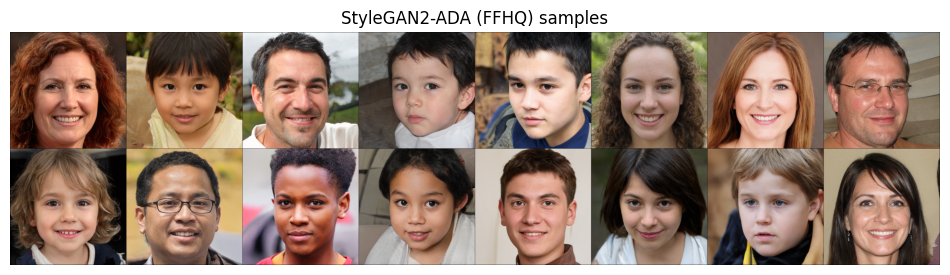

In [87]:
# ============================================================
# [StyleGAN] Generate photorealistic FFHQ samples
# ============================================================

import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

@torch.no_grad()
def sample_stylegan(G, n=16, seed=7, truncation_psi=0.7):
    rnd = np.random.RandomState(seed)
    z = torch.from_numpy(rnd.randn(n, G.z_dim)).to(device).float()
    img = G(z, None, truncation_psi=truncation_psi, noise_mode="const")  # [-1,1]
    img = (img * 0.5 + 0.5).clamp(0, 1)  # [0,1]
    return img.cpu()

style_imgs = sample_stylegan(G, n=16, seed=7, truncation_psi=0.7)
grid_style = make_grid(style_imgs, nrow=8)

plt.figure(figsize=(12,6))
plt.imshow(grid_style.permute(1,2,0))
plt.axis("off")
plt.title("StyleGAN2-ADA (FFHQ) samples")
plt.show()


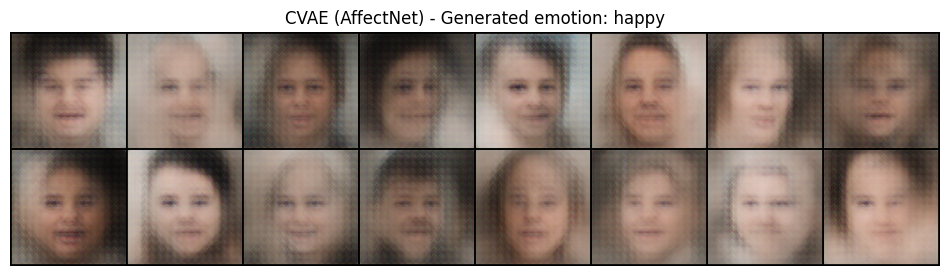

In [88]:
# ============================================================
# [CVAE] Generate conditional samples for one emotion
# ============================================================

import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

@torch.no_grad()
def generate_cvae_emotion(cvae_model, emotion_name="happy", n=16, latent_dim=256):
    cvae_model.eval()
    emo_id = CLASSES.index(emotion_name)

    z = torch.randn(n, latent_dim).to(device)
    y = torch.full((n,), emo_id, dtype=torch.long).to(device)
    y_oh = one_hot(y, len(CLASSES)).to(device)

    zy = torch.cat([z, y_oh], dim=1)

    # CVAE128 decoder path: 256 x 8 x 8
    h = cvae_model.fc_decode(zy).view(n, 256, 8, 8)
    xgen = cvae_model.decoder(h).clamp(0,1).cpu()
    return xgen

emotion_to_show = "happy"   
cvae_imgs = generate_cvae_emotion(cvae, emotion_name=emotion_to_show, n=16, latent_dim=latent_dim)
grid_cvae = make_grid(cvae_imgs, nrow=8)

plt.figure(figsize=(12,6))
plt.imshow(grid_cvae.permute(1,2,0))
plt.axis("off")
plt.title(f"CVAE (AffectNet) - Generated emotion: {emotion_to_show}")
plt.show()


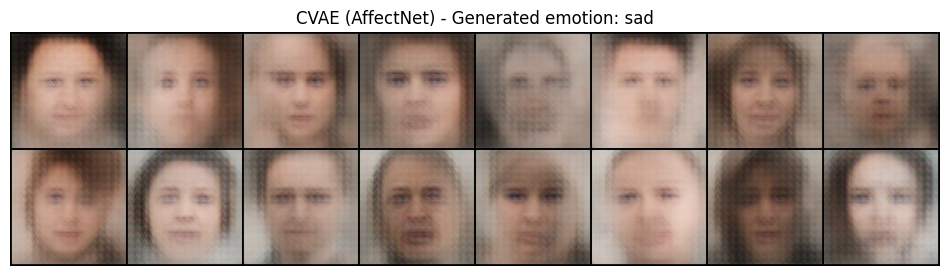

In [120]:
# ============================================================
# [CVAE] Generate conditional samples for one emotion
# ============================================================

import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

@torch.no_grad()
def generate_cvae_emotion(cvae_model, emotion_name="sad", n=16, latent_dim=256):
    cvae_model.eval()
    emo_id = CLASSES.index(emotion_name)

    z = torch.randn(n, latent_dim).to(device)
    y = torch.full((n,), emo_id, dtype=torch.long).to(device)
    y_oh = one_hot(y, len(CLASSES)).to(device)

    zy = torch.cat([z, y_oh], dim=1)

    # CVAE128 decoder path: 256 x 8 x 8
    h = cvae_model.fc_decode(zy).view(n, 256, 8, 8)
    xgen = cvae_model.decoder(h).clamp(0,1).cpu()
    return xgen

emotion_to_show = "sad"   
cvae_imgs = generate_cvae_emotion(cvae, emotion_name=emotion_to_show, n=16, latent_dim=latent_dim)
grid_cvae = make_grid(cvae_imgs, nrow=8)

plt.figure(figsize=(12,6))
plt.imshow(grid_cvae.permute(1,2,0))
plt.axis("off")
plt.title(f"CVAE (AffectNet) - Generated emotion: {emotion_to_show}")
plt.show()


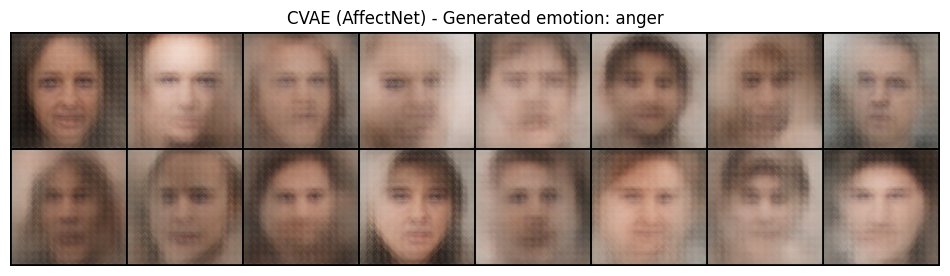

In [123]:
# ============================================================
# [CVAE] Generate conditional samples for one emotion
# ============================================================

import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

@torch.no_grad()
def generate_cvae_emotion(cvae_model, emotion_name="anger", n=16, latent_dim=256):
    cvae_model.eval()
    emo_id = CLASSES.index(emotion_name)

    z = torch.randn(n, latent_dim).to(device)
    y = torch.full((n,), emo_id, dtype=torch.long).to(device)
    y_oh = one_hot(y, len(CLASSES)).to(device)

    zy = torch.cat([z, y_oh], dim=1)

    # CVAE128 decoder path: 256 x 8 x 8
    h = cvae_model.fc_decode(zy).view(n, 256, 8, 8)
    xgen = cvae_model.decoder(h).clamp(0,1).cpu()
    return xgen

emotion_to_show = "anger"   
cvae_imgs = generate_cvae_emotion(cvae, emotion_name=emotion_to_show, n=16, latent_dim=latent_dim)
grid_cvae = make_grid(cvae_imgs, nrow=8)

plt.figure(figsize=(12,6))
plt.imshow(grid_cvae.permute(1,2,0))
plt.axis("off")
plt.title(f"CVAE (AffectNet) - Generated emotion: {emotion_to_show}")
plt.show()


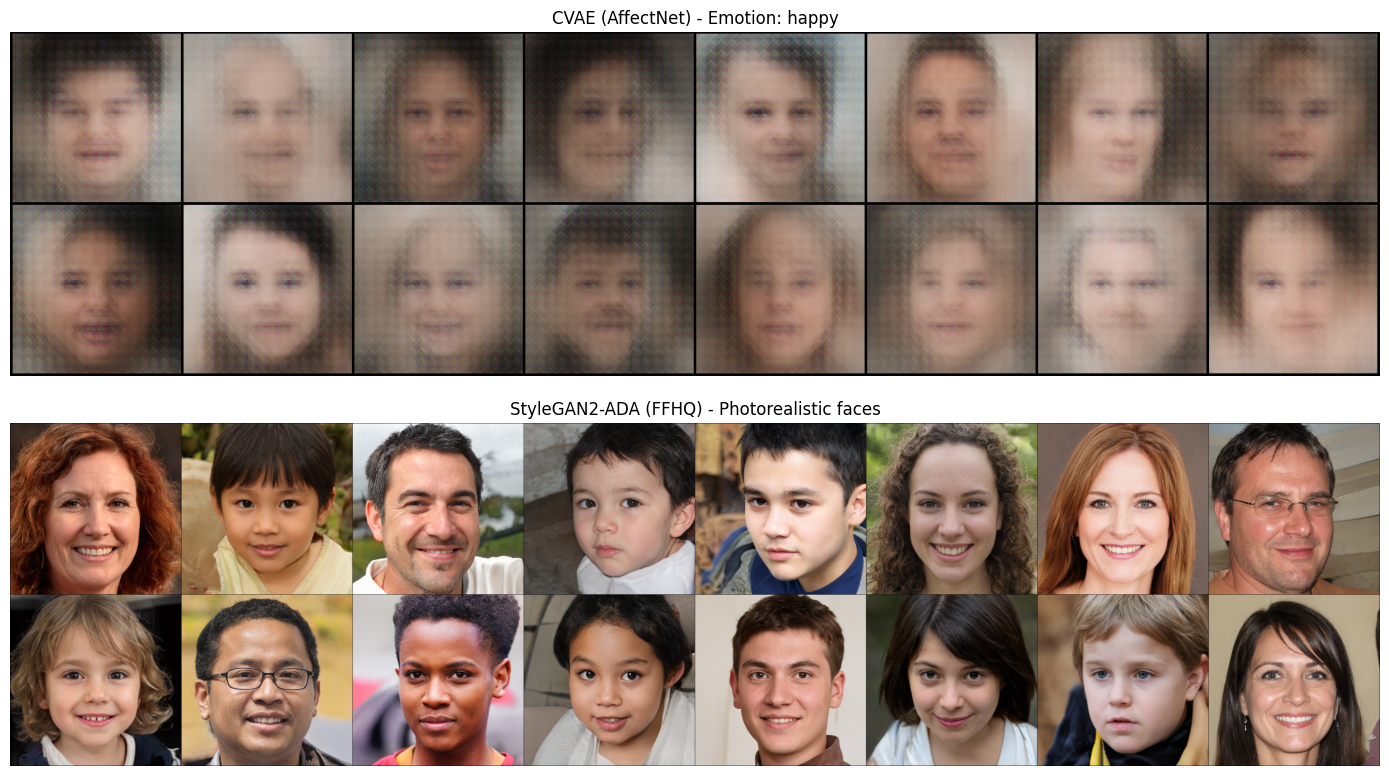

In [89]:
# ============================================================
# [Comparison] CVAE vs StyleGAN (one figure)
# ============================================================

plt.figure(figsize=(14,8))

plt.subplot(2,1,1)
plt.imshow(grid_cvae.permute(1,2,0))
plt.axis("off")
plt.title(f"CVAE (AffectNet) - Emotion: {emotion_to_show}")

plt.subplot(2,1,2)
plt.imshow(grid_style.permute(1,2,0))
plt.axis("off")
plt.title("StyleGAN2-ADA (FFHQ) - Photorealistic faces")

plt.tight_layout()
plt.show()


In [90]:
# ============================================================
# Save comparison figure 
# ============================================================

import os
from PIL import Image

os.makedirs("/kaggle/working/outputs/samples", exist_ok=True)

# Sauvegarder les deux grilles séparément
cvae_path = "/kaggle/working/outputs/samples/cvae_generated.png"
style_path = "/kaggle/working/outputs/samples/stylegan_generated.png"

Image.fromarray((grid_cvae.permute(1,2,0).numpy()*255).astype(np.uint8)).save(cvae_path)
Image.fromarray((grid_style.permute(1,2,0).numpy()*255).astype(np.uint8)).save(style_path)

print("Saved:", cvae_path)
print("Saved:", style_path)


Saved: /kaggle/working/outputs/samples/cvae_generated.png
Saved: /kaggle/working/outputs/samples/stylegan_generated.png


vérifier l’émotion générée par CVAE avec ton classifieur

In [115]:
# ============================================================
# Check what the classifier thinks about CVAE generated images
# ============================================================

import torch

clf.eval()
with torch.no_grad():
    logits = clf(cvae_imgs.to(device))
    pred = logits.argmax(1).cpu().numpy()

# compter les prédictions
from collections import Counter
cnt = Counter(pred)

print("Classifier predictions on CVAE generated images:")
for k, v in cnt.items():
    print(f"{idx_to_class[int(k)]:10s}: {v}")


Classifier predictions on CVAE generated images:
happy     : 7
neutral   : 9


In [119]:
# ============================================================
# Check what the classifier thinks about CVAE generated images
# ============================================================

import torch
from collections import Counter

clf.eval()
with torch.no_grad():
    logits = clf(cvae_imgs.to(device))
    pred = logits.argmax(1).cpu().numpy()

cnt = Counter(pred)
total = len(pred)

print("Classifier predictions on CVAE generated images:")
for k, v in cnt.items():
    name = idx_to_class[int(k)]
    print(f"{name:10s}: {v:3d} ({100*v/total:5.1f}%)")


Classifier predictions on CVAE generated images:
happy     :   7 ( 43.8%)
neutral   :   9 ( 56.2%)
